<a href="https://colab.research.google.com/github/mthoko-n/Comp315Project/blob/main/COMP703_Assignment_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [24]:
#!pip install hmmlearn
import pandas as pd
import numpy as np
from sklearn.model_selection import GroupShuffleSplit
from sklearn.preprocessing import LabelEncoder
from hmmlearn import hmm
import matplotlib.pyplot as plt
import seaborn as sns

Pre processing of dataset.

In [ ]:
#Getting the data
sentences = []
sentence_number = 1
with open("ss.gold.train", "r", encoding="utf-8") as file:
    next(file)
    current_sentence = []
    for line in file:
        if not line.strip():
            if current_sentence:
                sentences.append(current_sentence)
                current_sentence = []
            continue
        columns = line.strip().split("\t")
        token = columns[0]
        upos = columns[4]
        current_sentence.append((sentence_number, token, upos))
        if token == '.':
            sentence_number += 1

data = []
for sentence in sentences:
    for sentence_number, token, upos in sentence:
        data.append([sentence_number, token, upos])

df = pd.DataFrame(data, columns=['Sentence', 'Token', 'UPOS'])
print(df[:60])


In [20]:
#Getting the vocabulary and tags
tags = list(set((df["UPOS"])))
vocabulary = list(set((df["Token"])))

len(tags), len(vocabulary)

(16, 14060)

In [45]:
#Spliting the data into training and testing datasets.
y = df.UPOS
X = df.drop('UPOS', axis=1)

group_spliter = GroupShuffleSplit(n_splits=2, test_size=.20, random_state=101)
train_X, test_X = next(group_spliter.split(X, y, groups=df['Sentence']))

train_data = df.loc[train_X]
test_data = df.loc[test_X]

test_data[:30]

,Sentence,Token,UPOS
77,5,Tindzawo,N
78,5,letingephandle,REL
79,5,:,PUNC
80,5,Leti,CDEM
81,5,tibuya,V
82,5,ngaphandle,ADV
83,5,kwamasipala,POSS
84,5,njengemali,ADV
85,5,lebolekwe,REL
86,5,etigungwini,N


In [63]:
#Handling Unknown.

dfunknown = train_data.sample(frac=.05, replace=False, random_state=101) #5% of random words in the training set.
dfunknown.Token = "<UNK>"                                                #Set the 5% of words to Unkown word tag.
train_data.update(dfunknown)

In [64]:
#Check of the size of vocabulary and tags in the training dataset.
tags = list(set(train_data.UPOS.values))
vocabulary = list(set(train_data.Token.values))

len(tags), len(vocabulary)

(16, 11569)

In [102]:
#Enumerating words and tags.
word_encoder = LabelEncoder()
tag_encoder = LabelEncoder()

vocabulary_encoded = word_encoder.fit_transform(vocabulary)
tags_encoded = tag_encoder.fit_transform(tags)


#print( word_encoder.transform(["kuna"])[0])
#print(word_encoder.classes_[4250])

9
V


In [100]:
#Number of occurrence of each tag.
tag_count = dict(train_data.UPOS.value_counts())

#Number of times each tag is associated to a word.
tags_to_words_count = train_data.groupby(['UPOS']).apply(lambda grp: grp.groupby('Token')['UPOS'].count().to_dict()).to_dict()

#Number of times each tag is at the start of a senctance.
tag_start_count = dict(train_data.groupby('Sentence').first().UPOS.value_counts())
numberOf_sentences = sum(tag_start_count.values())

In [ ]:
#Setting up Transation count table
transation_count = np.zeros((len(tags), len(tags)), dtype=int)

sentences = list(train_data.Sentence)
upos = list(train_data.UPOS)
for i in range(len(sentences)) :
    if (i > 0) and (sentences[i] == sentences[i - 1]):
        nexttag = tag_encoder.transform([upos[i]])[0]
        prevtag = tag_encoder.transform([upos[i - 1]])[0]
        transation_count[prevtag][nexttag] += 1

In [132]:
#Setting up the parameters of the HMM model
startprob = np.zeros((len(tags),))
transmat = np.zeros((len(tags), len(tags)))
emissionprob = np.zeros((len(tags), len(vocabulary)))

transation_count_row_sums = np.sum(transation_count, axis=1)

for tag in tag_encoder.classes_:

    tag_index = tag_encoder.transform([tag])[0]
    startprob[tag_index] = tag_start_count.get(tag, 0) / numberOf_sentences
    if tag in tag_count:
      floatCountTag = float(tag_count[tag])
    else:
      floatCountTag = 0.0

    for word in word_encoder.classes_:
        word_index = word_encoder.transform([word])[0]
        emissionprob[tag_index][word_index]= tags_to_words_count.get(tag, {}).get(word, 0) / floatCountTag

    for tag2 in tag_encoder.classes_:
        tag_index2 = tag_encoder.transform([tag2])[0]
        transmat[tag_index][tag_index2]= transation_count[tag_index][tag_index2] / transation_count_row_sums[tag_index]

emissionprob

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.00022282, 0.0026738 , 0.02094474, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [ ]:
#Initializing Model
model = hmm.MultinomialHMM(n_components=len(tags), algorithm='viterbi', random_state=101)
model.startprob_ = startprob
model.transmat_ = transmat
model.emissionprob_ = emissionprob

Transition Matrix:


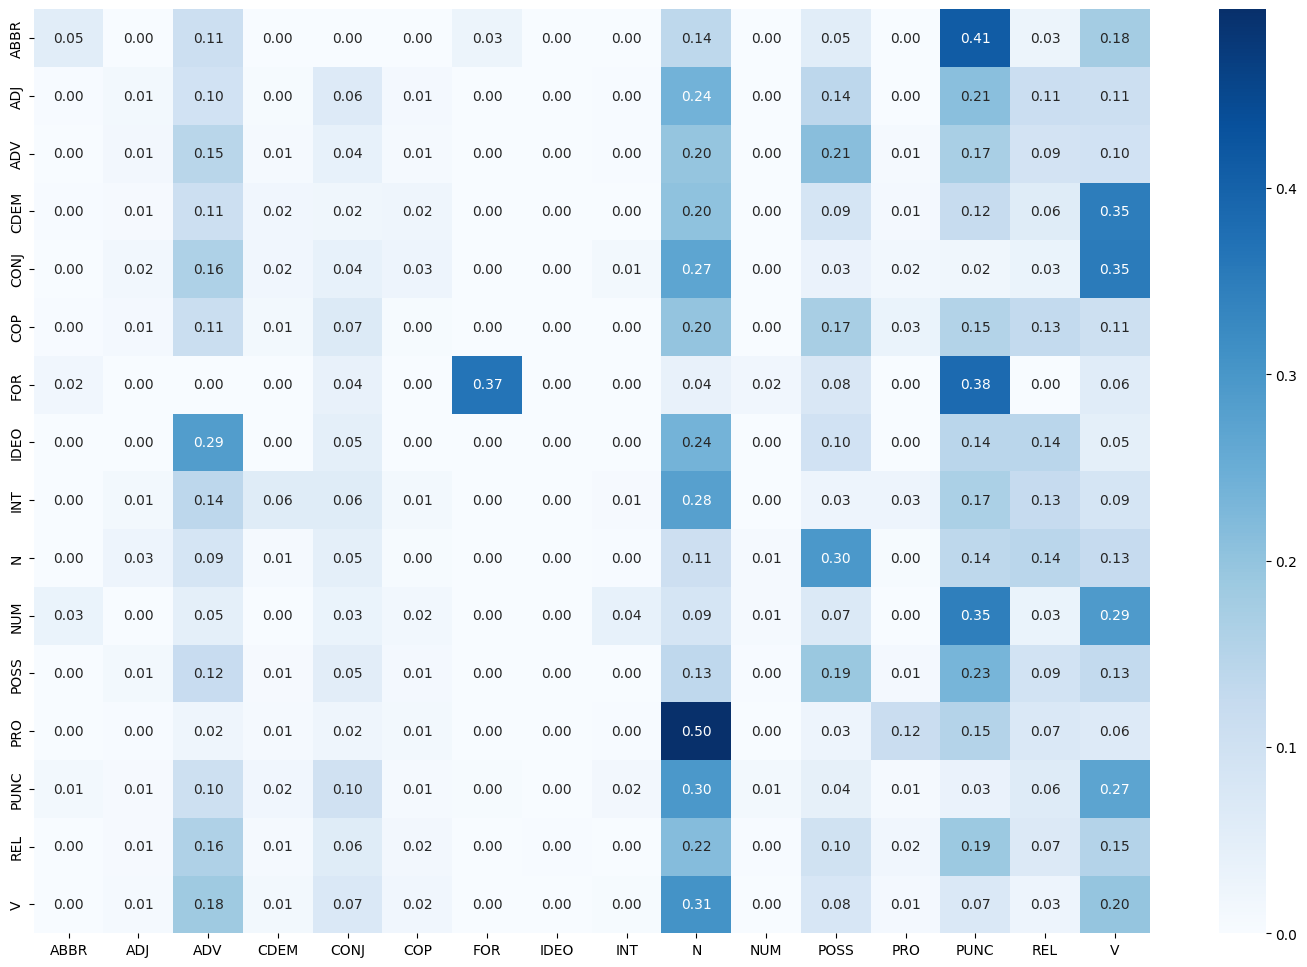

In [139]:
#Model Transition Table
transition_matrix = model.transmat_
num_hidden_states = transition_matrix.shape[0]
Y_decoded = tag_encoder.classes_
transition_df = pd.DataFrame(transition_matrix, columns=Y_decoded, index=Y_decoded)

print("Transition Matrix:")
plt.figure(figsize=(18, 12))
sns.heatmap(transition_df, annot=True, fmt=".2f", cmap="Blues")  # Adjust fmt for better display of probabilities
plt.show()

In [135]:
#Emission Table
emission_matrix = model.emissionprob_
emission_matrix.shape

(16, 11569)

Hiddin Markov Model Testing

In [ ]:
#Marking unknown words with unknown word tag (<UNK>)
data_test.loc[~data_test['Word'].isin(words), 'Word'] = 'UNKNOWN'
word_test = list(data_test.Word)
samples = []
for i, val in enumerate(word_test):
    samples.append([word2id[val]])

# TODO use panda solution
lengths = []
count = 0
sentences = list(data_test.sentence)
for i in range(len(sentences)) :
    if (i > 0) and (sentences[i] == sentences[i - 1]):
        count += 1
    elif i > 0:
        lengths.append(count)
        count = 1
    else:
        count = 1

,TOKEN_encoded,UPOS_encoded
35481,3639,9
33696,1185,3
21407,3466,9
33569,13281,11
35466,11825,11
...,...,...
6265,1760,9
11284,12224,15
38158,13559,11
860,1739,9


In [137]:
import numpy as np

# Assuming you have defined startprob, transmat, and emissionprob matrices

# Save the matrices to a NPZ file
np.savez('model_params.npz', startprob=startprob, transmat=transmat, emissionprob=emissionprob)

In [138]:
# Load the matrices from the NPZ file
data = np.load('model_params.npz')
startprob = data['startprob']
transmat = data['transmat']
emissionprob = data['emissionprob']


startprob

array([0.0037296 , 0.01724942, 0.06247086, 0.07179487, 0.05734266,
       0.01025641, 0.0004662 , 0.        , 0.00885781, 0.41398601,
       0.        , 0.02237762, 0.00979021, 0.0032634 , 0.03822844,
       0.28018648])